In [ ]:
path = r"/content/oracle.csv"

In [ ]:
# imports

import numpy as np
from numpy import array
import pandas as pd
import re
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

import gensim
from gensim.models import Word2Vec

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Activation, Dropout, Dense
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv(path)

print(df)

                                                 review  sentiment
0     This should read:\n\nThis survey tests the loc...          0
1     - Should be like below:\ntextDirection = SWT.A...          0
2     """create a vdsm.config.config clone, modified...          0
3     "Add test(s) performing the static code analys...          0
4     "apt-get" is distro specific... perhaps make i...          0
...                                                 ...        ...
1595  you'll need someone with some maven experience...          0
1596  Your memory is too smalll. Consider buying a R...          0
1597  You're preforming this check multiple times.\n...          0
1598  You're right. Ivan,tenant_id is non-admin tena...          0
1599  You're right. The issue is that the onSampleSe...          0

[1600 rows x 2 columns]


In [ ]:
# add column names

df.columns = ['review', 'sentiment']

print(df)

                                                 review  sentiment
0     This should read:\n\nThis survey tests the loc...          0
1     - Should be like below:\ntextDirection = SWT.A...          0
2     """create a vdsm.config.config clone, modified...          0
3     "Add test(s) performing the static code analys...          0
4     "apt-get" is distro specific... perhaps make i...          0
...                                                 ...        ...
1595  you'll need someone with some maven experience...          0
1596  Your memory is too smalll. Consider buying a R...          0
1597  You're preforming this check multiple times.\n...          0
1598  You're right. Ivan,tenant_id is non-admin tena...          0
1599  You're right. The issue is that the onSampleSe...          0

[1600 rows x 2 columns]


In [ ]:
print("DataFrame shape:", df.shape)

DataFrame shape: (1600, 2)


In [ ]:
# check if there are any null values

df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

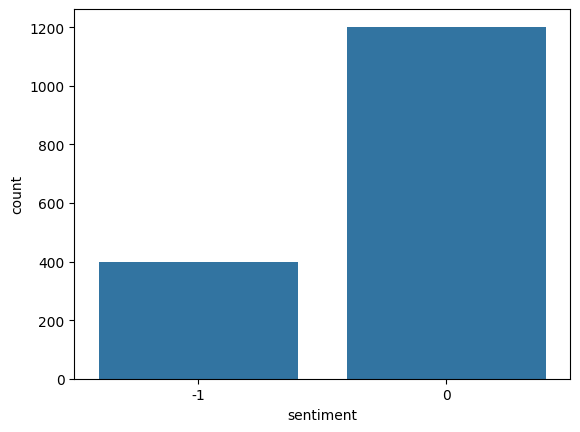

In [ ]:
# check if the data is skewed

sns.countplot(x='sentiment', data=df)

In [ ]:
df["review"][1]

'- Should be like below:\ntextDirection = SWT.AUTO_TEXT_DIRECTION;'

In [ ]:
# function for processing the reviews

def preprocess_text(sen):
  sentence = sen.lower()
  sentence = re.sub(r'\s+', ' ', sentence)  # removes consecutive whitespaces
  sentence = re.sub(r'```.*?```', '', sentence, flags=re.DOTALL)  # Remove code snippets (assumed to be between ``` and ```)
  sentence = re.sub(r'http\S+', '', sentence)  # Remove URLs
  sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence)  # Remove special characters and punctuation
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')  # removes stopwords
  sentence = pattern.sub('', sentence)

  return sentence

In [ ]:
# process the reviews

X = []
sentences = list(df['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [ ]:
X[0]

'read survey tests local metadata performance using echoclient drive mdd layer perform operations run multiple threads simulate mdt service threads locally mds node need lustre clients order run'

In [ ]:
pd.DataFrame(X)

,0
0,read survey tests local metadata performance u...
1,like textdirection swtautotextdirection
2,create vdsmconfigconfig clone modified tunable...
3,add tests performing static code analysis usin...
4,aptget distro specific perhaps make clear exam...
...,...
1595,youll need someone maven experience review
1596,memory smalll consider buying ram
1597,youre preforming check multiple times better c...
1598,youre right ivantenantid nonadmin tenant need ...


In [ ]:
print(len(X))

1600


In [ ]:
y = df['sentiment']

In [ ]:
# find the vocab size

tokenized_reviews = [word_tokenize(review) for review in X]

# Flatten the list of tokens
all_tokens = [token for review_tokens in tokenized_reviews for token in review_tokens]

# Count the frequency of each token
token_freq = Counter(all_tokens)

# Filter out tokens with frequency less than a threshold (optional)
min_token_freq = 1
filtered_token_freq = {token: freq for token, freq in token_freq.items() if freq >= min_token_freq}

# Add special tokens like <UNK> and <PAD> if necessary
special_tokens = ['<UNK>', '<PAD>']
total_vocab = special_tokens + list(filtered_token_freq.keys())

# Calculate the vocab_size
vocab_size = len(total_vocab)

print("Vocabulary Size:", vocab_size)
pd.DataFrame(tokenized_reviews)

Vocabulary Size: 6149


,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,read,survey,tests,local,metadata,performance,using,echoclient,drive,mdd,...,None,None,None,None,None,None,None,None,None,None
1,like,textdirection,swtautotextdirection,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,create,vdsmconfigconfig,clone,modified,tunables,tunables,list,section,key,val,...,None,None,None,None,None,None,None,None,None,None
3,add,tests,performing,static,code,analysis,using,cppcheck,None,None,...,None,None,None,None,None,None,None,None,None,None
4,aptget,distro,specific,perhaps,make,clear,example,systems,would,installed,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,youll,need,someone,maven,experience,review,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1596,memory,smalll,consider,buying,ram,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1597,youre,preforming,check,multiple,times,better,create,separate,function,case,...,None,None,None,None,None,None,None,None,None,None
1598,youre,right,ivantenantid,nonadmin,tenant,need,change,admin,tennt,id,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Train Word2Vec embeddings
embedding_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Get word embeddings for each token in each code review
embedded_reviews = []

for review_tokens in tokenized_reviews:
    embedded_review = [embedding_model.wv[token] for token in review_tokens if token in embedding_model.wv]
    embedded_reviews.append(embedded_review)

pd.DataFrame(embedded_reviews)

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,"[-0.013733806, 0.017403655, 0.0034375608, -0.0...","[0.007050179, 0.006186416, -0.009493965, -0.00...","[-0.000687796, 0.018571205, 0.011525721, 0.006...","[-0.003492711, -0.0008700083, 0.011618467, -0....","[0.0031636835, -0.006898835, -0.0039490894, 0....","[-0.011662851, 0.01233007, -0.007887543, 0.009...","[-0.023445839, 0.013334639, 0.018805062, 0.002...","[-6.2306084e-05, -0.0043720496, 0.006826392, -...","[0.00033305405, 0.0063052466, -0.009115054, 0....","[0.0073875925, 0.00035514272, 0.0047000297, -0...",...,None,None,None,None,None,None,None,None,None,None
1,"[-0.01552205, 0.023036793, 0.019955821, 0.0097...","[0.0025958589, 0.0065522646, 0.0075014555, -0....","[-0.00043395822, 0.0026158697, 0.0038516752, -...",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"[-0.015651809, 0.0064392476, 0.0053836047, 0.0...","[0.009328631, 0.0034395421, -0.00012938616, 0....","[-0.00057142007, 0.0035935289, -0.0063334624, ...","[0.0011986552, 0.0021327115, -0.001597688, -0....","[0.003077926, -0.005053713, -0.0038992707, -0....","[0.003077926, -0.005053713, -0.0038992707, -0....","[-0.010850712, 0.015428385, -0.002255554, 0.00...","[-0.003116599, -0.003118095, -0.003975805, 0.0...","[-0.0014169208, 0.0036077583, -0.0020597405, 0...","[-0.008138148, -0.0030682734, 0.0053839535, 0....",...,None,None,None,None,None,None,None,None,None,None
3,"[-0.015184472, 0.022685133, 0.01844572, -0.009...","[-0.000687796, 0.018571205, 0.011525721, 0.006...","[-0.0074935635, -0.0054319026, -0.004359677, -...","[-0.015677681, 0.011013403, 0.006537864, -0.00...","[-0.03620781, 0.040071726, 0.0127226785, -0.00...","[-0.008839115, -0.0039750636, -0.0074019516, 0...","[-0.023445839, 0.013334639, 0.018805062, 0.002...","[0.005326327, 0.0050003603, -0.00877725, 0.009...",None,None,...,None,None,None,None,None,None,None,None,None,None
4,"[0.0068295845, -0.0067416662, -0.0029187764, 0...","[-0.008672754, 0.0010067801, 0.005192712, 0.00...","[0.003923937, 0.012326445, 0.0012450767, -0.00...","[0.0031157022, 0.007876356, -0.00019854015, -0...","[-0.015642326, 0.036243368, 0.012015814, -0.00...","[-0.0041181846, -0.0007675203, -0.00011701471,...","[-6.2645755e-05, 0.0019723417, 0.0036846937, -...","[0.00057429203, 0.0073702554, -4.2363412e-05, ...","[-0.032653484, 0.034476176, 0.019008186, 0.011...","[0.0046019563, 0.010411584, 8.46008e-05, -0.00...",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,"[-0.010241303, -0.005926629, 0.0048849927, 0.0...","[-0.028438741, 0.03375373, 0.0053576883, 0.000...","[-0.005008459, -0.0026095277, 0.008973285, 0.0...","[0.00096830557, 0.0034462041, 0.005574894, 0.0...","[0.004972676, -0.007065202, -0.008183691, 0.00...","[-0.0073888344, -0.0016247185, -0.005558369, -...",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1596,"[-0.012083591, 0.015739242, 0.00699125, 0.0048...","[-0.0022220288, -0.0039299796, 0.0028749886, -...","[0.002924052, 0.004611847, -0.0020362479, 0.00...","[-0.005949728, 0.00062700495, 0.004658116, 0.0...","[-0.00582833, -0.0030220363, 0.0032344214, 0.0...",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1597,"[-0.004445769, 0.0029960019, 0.012488307, 0.00...","[0.004574364, -0.0008824682, 0.009020521, -0.0...","[-0.008843056, 0.008610901, -0.0009736115, -0....","[-0.0039161467, 0.009369551, -0.003183256, -0....","[7.395005e-05, -0.006483069, 0.009934837, 0.01...","[-0.0143443765, 0.015946964, 0.004395165, 0.00...","[-0.015651809, 0.0064392476, 0.0053836047, 0.0...","[-0.015092302, 0.009185363, -0.0053655207, 0.0...","[-0.02066382, 0.026809504, 0.01078937, 0.01132...","[-0.009780477, 0.030232904, 0.010358735, -0.00...",...,None,None,None,None,None,None,None,None,None,None
1598,"[-0.004445769, 0.0029960019, 0.012488307, 0.00...","[-0.020509476, 0.0

In [ ]:
# add padding to bring all reviews to the same length

max_length = max(len(review) for review in embedded_reviews)
print(max_length)

# Pad sequences to the maximum length
X_padded = pad_sequences(embedded_reviews, maxlen=max_length, padding='post', truncating='post', dtype='float32')

print("Shape of padded reviews:", X_padded.shape)
print("Example padded review:")
print(X_padded[0])
print("Example padded review:")
print(X_padded[-1])

145
Shape of padded reviews: (1600, 145, 100)
Example padded review:
[[-0.01373381  0.01740365  0.00343756 ... -0.02231099  0.00326482
  -0.00057152]
 [ 0.00705018  0.00618642 -0.00949396 ...  0.00477864 -0.000637
   0.00458712]
 [-0.0006878   0.01857121  0.01152572 ... -0.01592992  0.00453083
   0.001937  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Example padded review:
[[-0.00444577  0.002996    0.01248831 ... -0.00387594 -0.00606805
   0.00209064]
 [-0.02050948  0.01101444 -0.00083382 ... -0.02377857  0.00178523
   0.00488736]
 [-0.01635116  0.0036167   0.00720294 ... -0.0098714   0.00171201
  -0.00409742]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.   

In [ ]:
# split the data to train and test (80/20)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.20, random_state=42)

In [ ]:
# convert series data to numpy array

print(type(y_train))
y_train_array = y_train.values
y_test_array = y_test.values

<class 'pandas.core.series.Series'>


In [ ]:
# model definition and training

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy arrays to PyTorch tensors for training set
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)

# Create the training DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# Convert numpy arrays to PyTorch tensors for testing set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

# Create the testing DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):

        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):

        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

input_size = 100
hidden_size = 128
num_layers = 2
num_classes = 2
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_total_steps = len(train_loader)
for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_loader):

        # Forward pass
        # map -1 to 0 and 0 to 1
        labels = (labels == 0).long()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/5], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [10/13], Loss: 0.5554
Epoch [2/5], Step [10/13], Loss: 0.5678
Epoch [3/5], Step [10/13], Loss: 0.5393
Epoch [4/5], Step [10/13], Loss: 0.5737
Epoch [5/5], Step [10/13], Loss: 0.6523
Epoch [6/5], Step [10/13], Loss: 0.5729
Epoch [7/5], Step [10/13], Loss: 0.5424
Epoch [8/5], Step [10/13], Loss: 0.5856
Epoch [9/5], Step [10/13], Loss: 0.6027
Epoch [10/5], Step [10/13], Loss: 0.5515


In [ ]:
# evaluating the model

model.eval()

correct = 0
total = 0
true_values = []
predicted_values = []

# Iterate through the test data
with torch.no_grad():
    for inputs, labels in test_loader:

        # Forward pass
        outputs = model(inputs)

        # Convert probabilities to predicted class (0 or 1)
        _, predicted = torch.max(outputs.data, 1)

        # map -1 to 0 and 0 to 1
        normalized_labels = (labels == 0).float()

        true_values.extend(normalized_labels.cpu().numpy())
        predicted_values.extend(predicted.cpu().numpy())

        # Accumulate total and correct predictions
        total += labels.size(0)
        correct += (predicted == normalized_labels).sum().item()

# Calculate accuracy
accuracy = correct / total

print('Accuracy on test data:', accuracy)

Accuracy on test data: 0.7625
